# Assignment 3
### Ritirupa Dey(MDS202136)
### Shramana Guin(MDS202143)

## Loading necessary libraries

In [1]:
%load_ext memory_profiler

In [2]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
%matplotlib inline
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)

import time

# Loading and Preprocessing Data

## Splitting into train-test sets

In [3]:
fashion_mnist = keras.datasets.fashion_mnist
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
class_names=['T-shirt/top','Trouser','Pullover','Dress','Coat','Sandal','Shirt',
            'Sneaker','Bag','Ankle Boot']

## Normalizing

In [4]:
X_train=X_train/255.00
X_test = X_test / 255.00

In [5]:
X_test.shape, X_train.shape, y_test.shape, y_train.shape

((10000, 28, 28), (60000, 28, 28), (10000,), (60000,))

## Viewing a random image

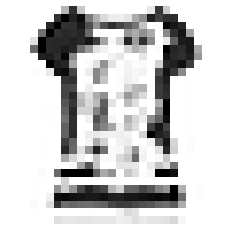

In [6]:
np.random.seed(42)
plt.imshow(X_train[np.random.randint(0,55000)], cmap="binary")
plt.axis('off')
plt.show()

## Unfolding the images into vectors

In [7]:
X_train_2d = X_train.reshape(X_train.shape[0],-1)         #Converting 28*28 image arrays to 784-D vectors
X_test_2d = X_test.reshape(X_test.shape[0],-1)     #Converting 28*28 image arrays to 784-D vectors

# -------------------------------------------------------------------------------------------------------------

# Performing Logistic Regression on the entire training set

In [8]:
%%time
%%memit
log_reg1 = LogisticRegression(multi_class="ovr", solver="saga", max_iter=2500, random_state=42)
log_reg1.fit(X_train_2d, y_train)

peak memory: 825.91 MiB, increment: 69.91 MiB
Wall time: 46min 11s


In [9]:
print(log_reg1.score(X_test_2d, y_test)*100,"%")

84.1 %


# Performing clustering using K-Means followed by Logistic Regression on the entire training set

In [10]:
%%time
%%memit
k=[100,200,300]
pipeline=np.empty(len(k),dtype=object)
for i in range(len(k)):
    pipeline[i] = Pipeline([("kmeans", KMeans(init='k-means++',n_clusters=k[i], random_state=42)),
                         ("log_reg", LogisticRegression(multi_class="ovr", solver="saga",
                                                        max_iter=2500, random_state=42))])
    pipeline[i].fit(X_train_2d, y_train)
    print('Cluster= {}, Accuracy= {}'.format(k[i],
            pipeline[i].score(X_test_2d,y_test)))

Cluster= 100, Accuracy= 0.8257
Cluster= 200, Accuracy= 0.8364
Cluster= 300, Accuracy= 0.8446
peak memory: 1523.45 MiB, increment: 699.75 MiB
Wall time: 2h 50min 6s


# --------------------------------------------------------------------------------------------------------------

# Performing Logistic Regression on Random Labelled Instances

In [11]:
%%time
%%memit
k=[500,1000,2000]
log_reg2=np.empty(len(k),dtype=object)
for i in range(len(k)):
    log_reg2[i] = LogisticRegression(multi_class="ovr", solver="saga", random_state=42)
    log_reg2[i].fit(X_train_2d[:k[i]], y_train[:k[i]])
    print('Labelled Instance= {}, Accuracy= {}'.format(k[i],
            log_reg2[i].score(X_test_2d,y_test)*100,"%"))

Labelled Instance= 500, Accuracy= 78.52
Labelled Instance= 1000, Accuracy= 79.24
Labelled Instance= 2000, Accuracy= 80.89
peak memory: 732.54 MiB, increment: 0.69 MiB
Wall time: 23.6 s


# ---------------------------------------------------------------------------------------------------------------

# Performing K-Means(K=2000) on the training set and choosing representative data points from each cluster

In [12]:
%%time
%%memit
kmeans1 = KMeans(init='k-means++',n_clusters=2000, random_state=42)
X_items_dist = kmeans1.fit_transform(X_train_2d)
representative_items_idx = np.argmin(X_items_dist, axis=0)
X_representative_items = X_train_2d[representative_items_idx]
y_representative_items = np.squeeze(y_train[representative_items_idx]).astype('int32')

peak memory: 2337.62 MiB, increment: 1605.03 MiB
Wall time: 16min 11s


In [13]:
y_representative_items = np.squeeze(y_train[representative_items_idx]).astype('int32')
print(np.array(class_names)[y_representative_items])

['Ankle Boot' 'T-shirt/top' 'T-shirt/top' ... 'Bag' 'Trouser' 'Ankle Boot']


# Fitting logistic regression on the representative instances

In [14]:
%%time
%%memit
log_reg3 = LogisticRegression(multi_class="ovr", solver="saga", max_iter=2500, random_state=42)
log_reg3.fit(X_representative_items, y_representative_items)
print('Accuracy= ',log_reg3.score(X_test_2d, y_test)*100,"%")

Accuracy=  81.64 %
peak memory: 1677.36 MiB, increment: 60.70 MiB
Wall time: 1min 32s


# ---------------------------------------------------------------------------------------------------------------

# Clustering and Propagating Labels to each Data Point

In [15]:
y_train_propagated = np.empty(len(X_train_2d), dtype=np.int32)
for i in range(2000):
    y_train_propagated[kmeans1.labels_==i] = y_representative_items[i]

## Fitting Logistic Regression to the entire training set with the propagated labels

In [16]:
%%time
%%memit
log_reg4 = LogisticRegression(multi_class="ovr", solver="saga", max_iter=2500, random_state=42)
log_reg4.fit(X_train_2d, y_train_propagated)
print(log_reg4.score(X_test_2d,y_test)*100,"%")

81.23 %
peak memory: 1685.56 MiB, increment: 7.98 MiB
Wall time: 47min 8s


# ---------------------------------------------------------------------------------------------------------------

# Clustering and Propagating Labels to Data Points Closer to Cluster Centroids

In [29]:
%%time
%%memit
percentile_closest = 20

X_cluster_dist = X_items_dist[np.arange(len(X_train_2d)), kmeans1.labels_]
for i in range(2000):
    in_cluster = (kmeans1.labels_ == i)
    cluster_dist = X_cluster_dist[in_cluster]
    cutoff_distance = np.percentile(cluster_dist, percentile_closest)
    above_cutoff = (X_cluster_dist > cutoff_distance)
    X_cluster_dist[in_cluster & above_cutoff] = -1

peak memory: 1087.23 MiB, increment: 0.07 MiB
Wall time: 1.01 s


In [30]:
partially_propagated = (X_cluster_dist != -1)
X_train_partially_propagated = X_train_2d[partially_propagated]
y_train_partially_propagated = y_train_propagated[partially_propagated]

## Fitting Logistic Regression to only the partially propagated labels

In [31]:
%%time
%%memit
log_reg5 = LogisticRegression(multi_class="ovr", solver="saga", max_iter=2500, random_state=42)
log_reg5.fit(X_train_partially_propagated, y_train_partially_propagated)
print(log_reg5.score(X_test_2d,y_test)*100,"%")

80.42 %
peak memory: 981.45 MiB, increment: 0.03 MiB
Wall time: 8min 51s


# ---------------------------------------------------------------------------------------------------------------